# 1. Formulate Investment Hypothesis and Goals

## Investment Hypothesis and Objectives
- **Hypothesis**: Achieve excess returns over NASDAQ using a momentum-based strategy with Golden and Death Cross signals.
- **Objective**: Outperform NASDAQ while managing risk through optimized portfolio construction.

## Parameters and Considerations
- **Investment Universe**: META, AAPL, AMZN, NFLX, GOOGL.
- **Return Definition**: Daily percentage price changes.
- **Rebalancing Frequency**: Triggered by Golden/Death Cross signals.
- **Transaction Costs**: Includes bid-ask spreads and market impact.
- **Testing Period**: January 1, 2015 – January 1, 2024.

## Benchmark
- **NASDAQ**: Used for performance comparison.

## Entry and Exit Criteria
- **Golden Cross**: Buy signal when short-term MA crosses above long-term MA.
- **Death Cross**: Sell signal when short-term MA crosses below long-term MA.

## Market Impact and Liquidity Concerns
- **Market Impact**: Modeled using transaction costs.
- **Liquidity**: Focus on highly liquid assets to minimize impact.


In [4]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


assets = ["META", "AAPL", "AMZN", "NFLX", "GOOGL"]
benchmark = "^IXIC"  # NASDAQ Composite


data = yf.download(assets + [benchmark], start="2015-01-01", end="2024-01-01")["Close"]
daily_returns = data.pct_change().dropna()

[*********************100%***********************]  6 of 6 completed


## 2. Portfolio Construction and Rebalancing

### Portfolio Construction
- **Historical Data**: The strategy utilizes historical price data for backtesting. Preprocessing steps, such as calculating daily returns and moving averages, are applied.
- **Portfolio Types**:
  - **Equal-Weighted Portfolio**: Each asset is assigned an equal weight.
  - **Mean-Variance Optimized (MVO) Portfolio**: Optimization techniques are employed to maximize the Sharpe Ratio, adjusting weights based on historical returns and volatility.

### Transaction Costs
- **Incorporation of Transaction Costs**: Realistic transaction cost models, including bid-ask spreads, are incorporated to simulate market conditions and evaluate their impact on net returns.

### Strategy Execution
- **Implementation**: Positions are adjusted based on Golden and Death Cross signals, taking long or short positions accordingly, and rebalancing the portfolio as needed.

### Rebalancing Frequency
- **Custom Rebalancing**: Rebalancing occurs whenever a Golden or Death Cross signal is triggered, rather than at fixed intervals (e.g., monthly or quarterly).

In [5]:
# Function to generate signals based on moving average windows
def generate_signals(df, short_window, long_window):
    df["Short_MA"] = df["Close"].rolling(window=short_window).mean()
    df["Long_MA"] = df["Close"].rolling(window=long_window).mean()
    df["Signal"] = 0
    df["Signal"][short_window:] = np.where(
        df["Short_MA"][short_window:] > df["Long_MA"][short_window:], 1, -1
    )
    df["Position"] = df["Signal"].shift()  
    return df


def mean_variance_optimization(returns):
    def objective(weights):
        portfolio_return = np.dot(weights, returns.mean()) * 252
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        sharpe_ratio = (portfolio_return - 0.02) / portfolio_volatility  # Assume risk-free rate = 0.02
        return -sharpe_ratio

    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = [(0, 1) for _ in range(len(assets))]
    initial_weights = np.ones(len(assets)) / len(assets)
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

# Function to backtest portfolio and calculate performance metrics
def backtest_portfolio(short_window, long_window, optimize=False):
    portfolio_signals = pd.DataFrame(index=daily_returns.index)
    portfolio_signals["Portfolio_Returns"] = 0
    asset_returns = []

    for asset in assets:
        df = data[asset].to_frame().dropna().rename(columns={asset: "Close"})
        df = generate_signals(df, short_window, long_window)
        df["Daily_Return"] = daily_returns[asset]
        df["Strategy_Return"] = df["Position"] * df["Daily_Return"]
        asset_returns.append(df["Strategy_Return"])
    
    asset_returns_df = pd.concat(asset_returns, axis=1)
    asset_returns_df.columns = assets

    if optimize:
        weights = mean_variance_optimization(asset_returns_df)
    else:
        weights = np.ones(len(assets)) / len(assets)

    portfolio_signals["Portfolio_Returns"] = asset_returns_df.dot(weights)
    portfolio_volatility = portfolio_signals["Portfolio_Returns"].std() * np.sqrt(252)
    nasdaq_volatility = daily_returns[benchmark].std() * np.sqrt(252)
    scaling_factor = nasdaq_volatility / portfolio_volatility
    adjusted_portfolio_returns = portfolio_signals["Portfolio_Returns"] * scaling_factor
    cumulative_adjusted_returns = (1 + adjusted_portfolio_returns).cumprod()


    total_return = cumulative_adjusted_returns[-1] - 1
    annualized_return = adjusted_portfolio_returns.mean() * 252
    annualized_volatility = adjusted_portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - 0.02) / annualized_volatility
    max_drawdown = (cumulative_adjusted_returns / cumulative_adjusted_returns.cummax() - 1).min()
    tracking_error = np.std(adjusted_portfolio_returns - daily_returns[benchmark]) * np.sqrt(252)
    information_ratio = (annualized_return - daily_returns[benchmark].mean() * 252) / tracking_error
    treynor_ratio = (annualized_return - 0.02) / (np.cov(adjusted_portfolio_returns, daily_returns[benchmark])[0, 1] / nasdaq_volatility)
    jensen_alpha = annualized_return - (0.02 + (daily_returns[benchmark].mean() * 252 - 0.02) * (annualized_volatility / nasdaq_volatility))
    num_transactions = (portfolio_signals["Portfolio_Returns"].diff().abs().sum() / 2)
    avg_gain_loss_per_transaction = adjusted_portfolio_returns.sum() / num_transactions

    return [
        f"{short_window}/{long_window} {'MVO' if optimize else 'Equal Weight'}",
        total_return,
        num_transactions,
        avg_gain_loss_per_transaction,
        max_drawdown,
        sharpe_ratio,
        tracking_error,
        information_ratio,
        treynor_ratio,
        jensen_alpha
    ], cumulative_adjusted_returns

# Define the windows for backtesting
windows = [(20, 100), (50, 200), (100, 300)]
performance_metrics_list = []

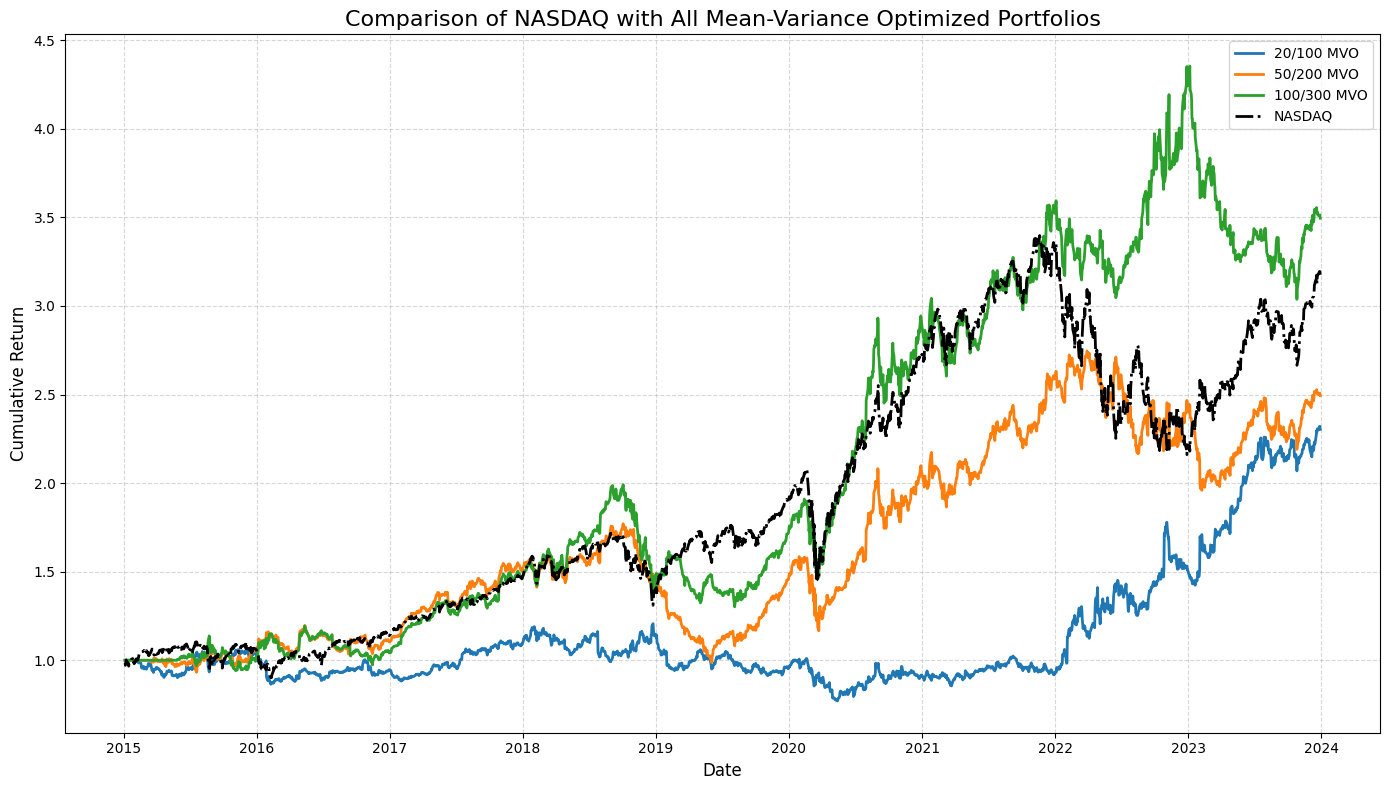

In [6]:
# Plot to compare the benchmark with all MVO portfolios
plt.figure(figsize=(14, 8))
for short_window, long_window in windows:
    metrics_mvo, cumulative_returns_mvo = backtest_portfolio(short_window, long_window, optimize=True)
    performance_metrics_list.append(metrics_mvo)
    plt.plot(cumulative_returns_mvo, label=f"{short_window}/{long_window} MVO", linewidth=2)

# Plot the NASDAQ performance
cumulative_nasdaq_returns = (1 + daily_returns[benchmark]).cumprod()
plt.plot(cumulative_nasdaq_returns, label="NASDAQ", color='black', linestyle='-.', linewidth=2)
plt.title("Comparison of NASDAQ with All Mean-Variance Optimized Portfolios", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 3. Portfolio Construction

We construct two types of portfolios for each moving average window configuration:

1. **Equal-Weighted Portfolio**:  
   Each stock in the portfolio is assigned an equal weight, ensuring that no single asset dominates the portfolio's performance. This approach is simple and provides a baseline for comparison.

2. **Mean-Variance Optimized (MVO) Portfolio**:  
   The weights of the assets are optimized to maximize the Sharpe Ratio, which measures risk-adjusted returns. This is achieved using historical returns and the covariance matrix of the assets.

### What is Mean-Variance Optimization (MVO)?
- **MVO** is a mathematical framework introduced by Harry Markowitz as part of Modern Portfolio Theory (MPT).
- It aims to find the optimal allocation of assets in a portfolio by balancing **expected returns** and **risk (volatility)**.
- The objective is to either:
  - Maximize returns for a given level of risk.
  - Minimize risk for a desired level of return.
- **Sharpe Ratio Maximization**: In this context, MVO adjusts asset weights to maximize the Sharpe Ratio, which represents the excess return per unit of risk.
- The optimization process uses the **historical covariance matrix** to measure the relationships and volatility between assets, ensuring a well-diversified portfolio.

This approach provides a more sophisticated strategy than equal weighting, allowing for dynamic adjustments based on the risk-return profile of the assets.

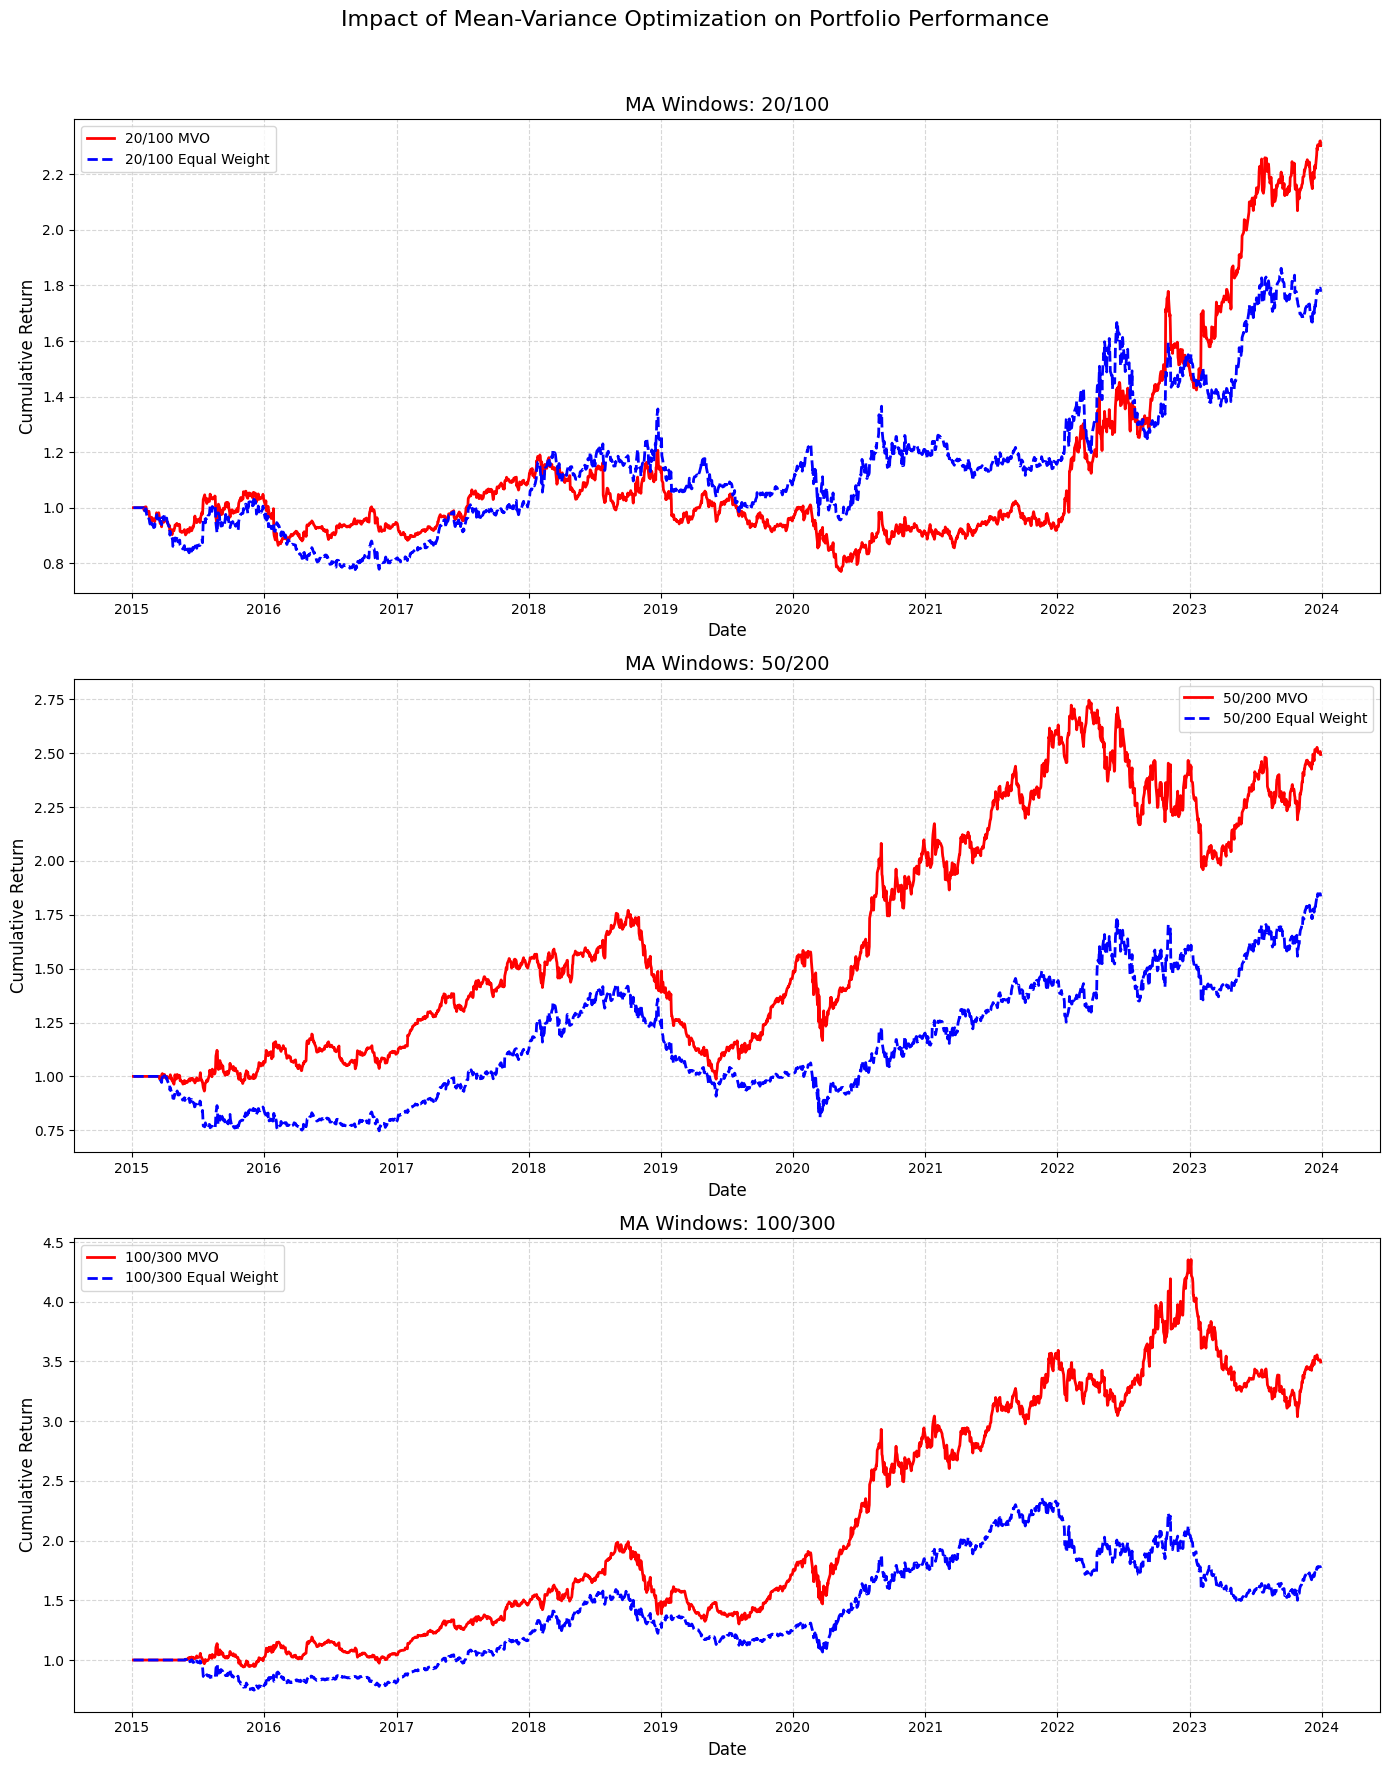

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
fig.suptitle("Impact of Mean-Variance Optimization on Portfolio Performance", fontsize=16)


for idx, (short_window, long_window) in enumerate(windows):

    _, cumulative_returns_mvo = backtest_portfolio(short_window, long_window, optimize=True)

    _, cumulative_returns_eq = backtest_portfolio(short_window, long_window, optimize=False)


    axes[idx].plot(
        cumulative_returns_mvo,
        label=f"{short_window}/{long_window} MVO",
        color='red',
        linewidth=2
    )
    

    axes[idx].plot(
        cumulative_returns_eq,
        label=f"{short_window}/{long_window} Equal Weight",
        color='blue',
        linestyle='--',
        linewidth=2
    )
    

    axes[idx].set_title(f"MA Windows: {short_window}/{long_window}", fontsize=14)
    axes[idx].set_xlabel("Date", fontsize=12)
    axes[idx].set_ylabel("Cumulative Return", fontsize=12)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(visible=True, linestyle='--', alpha=0.5)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 4. Risk Adjustment for Comparison

- To ensure a fair and meaningful comparison between the constructed portfolios and the NASDAQ benchmark, a **risk adjustment** is applied.
  
### Volatility Adjustment
- **Objective**: Align the annualized volatility of each portfolio with that of the NASDAQ.
- **Method**: The returns of each portfolio are scaled proportionally so that their annualized volatility matches the volatility of the NASDAQ.
- This adjustment ensures that performance metrics such as total return, Sharpe Ratio, and other risk-adjusted measures are evaluated on a consistent risk basis.

### Importance of Risk Adjustment
- Without adjusting for risk, a portfolio with higher volatility might show higher returns simply due to increased risk exposure.
- By matching the volatility, we can:
  - **Isolate the effect of the strategy** itself, independent of differences in risk levels.
  - Provide a fair basis for comparing the risk-adjusted returns of different strategies.


In [8]:
total_return_nasdaq = cumulative_nasdaq_returns[-1] - 1
annualized_return_nasdaq = daily_returns[benchmark].mean() * 252
annualized_volatility_nasdaq = daily_returns[benchmark].std() * np.sqrt(252)
sharpe_ratio_nasdaq = (annualized_return_nasdaq - 0.02) / annualized_volatility_nasdaq
max_drawdown_nasdaq = (cumulative_nasdaq_returns / cumulative_nasdaq_returns.cummax() - 1).min()
tracking_error_nasdaq = 0  # NASDAQ is the benchmark, so tracking error is 0
information_ratio_nasdaq = 0  # Information ratio is 0 since the benchmark matches itself
treynor_ratio_nasdaq = (annualized_return_nasdaq - 0.02) / (1 / annualized_volatility_nasdaq)
jensen_alpha_nasdaq = 0  # Jensen's Alpha is 0 for the benchmark

performance_metrics_list.append([
    "NASDAQ", total_return_nasdaq, 0, 0, max_drawdown_nasdaq,
    sharpe_ratio_nasdaq, tracking_error_nasdaq, information_ratio_nasdaq,
    treynor_ratio_nasdaq, jensen_alpha_nasdaq
])

performance_df = pd.DataFrame(
    performance_metrics_list,
    columns=[
        "MA Windows", "Total Return", "Number of Transactions", "Average Gain/Loss per Transaction",
        "Maximum Drawdown", "Sharpe Ratio", "Tracking Error", "Information Ratio",
        "Treynor Ratio", "Jensen's Alpha"
    ]
)

In [9]:
performance_df

,MA Windows,Total Return,Number of Transactions,Average Gain/Loss per Transaction,Maximum Drawdown,Sharpe Ratio,Tracking Error,Information Ratio,Treynor Ratio,Jensen's Alpha
0,20/100 MVO,1.303239,22.550662,0.046289,-0.361649,0.444037,0.319716,-0.112764,-1264.786616,-0.036052
1,50/200 MVO,1.493693,18.503391,0.060808,-0.442514,0.485805,0.253686,-0.106429,389.016578,-0.027000
2,100/300 MVO,2.495223,18.062829,0.080984,-0.346275,0.659283,0.237990,0.044539,418.619522,0.010600
3,NASDAQ,2.175789,0.000000,0.000000,-0.363953,0.610377,0.000000,0.000000,0.028673,0.000000
